In [1]:
import pandas as pd
import numpy as np
import json
import sys
sys.path.append('..')

In [2]:
from src import *
# with open('../assets/yelp_academic.json', 'r') as file:
#     review_df_info = json.load(file)

# with open('../assets/yelp_business.json', 'r') as file:
#     yelp_business_info = json.load(file)

# # 构建dtype字典
# review_df_dtype = {key: value['type']
#                        for key, value in yelp_academic_info.items()}
# yelp_business_dtype = {key: value['type']
#                        for key, value in yelp_business_info.items()}

In [3]:
# yelp_academic = pd.read_csv(
#     '../data/yelp_academic_dataset_review.csv',
#     encoding='utf-8',
#     dtype=yelp_academic_dtype)

# yelp_business = pd.read_csv(
#     '../data/yelp_academic_dataset_business.csv',
#     encoding='utf-8',
#     dtype=yelp_business_dtype)

In [4]:
business_df = pd.read_json('../data/Yelp Dataset/yelp_academic_dataset_business.json', lines=True)
checkin_df = pd.read_json('../data/Yelp Dataset/yelp_academic_dataset_checkin.json', lines=True)
review_df = pd.read_json('../data/Yelp Dataset/yelp_academic_dataset_review.json', lines=True)
tip_df = pd.read_json('../data/Yelp Dataset/yelp_academic_dataset_tip.json', lines=True)
user_df = pd.read_json('../data/Yelp Dataset/yelp_academic_dataset_user.json', lines=True)

这里查看每个城市的不同种类数量

In [5]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
PingFang = FontProperties(fname='../assets/PingFang.ttc')
plt.style.use('ggplot')

In [6]:
color_code = '#E5E5E5'
palette_key = 'Twisted Spot Palette'

try:
    with open('../assets/Palette.json', 'r') as file:
        data = json.load(file)
    if color_code in data:
        main_color = data[color_code].get(palette_key, [])
        print("主色调：", main_color)
except FileNotFoundError:
    ImportError("JSON文件格式不正确。")
except json.JSONDecodeError:
    ImportError("JSON文件格式不正确。")

主色调： ['#00754B', '#C8FCEA', '#6A9A8B']


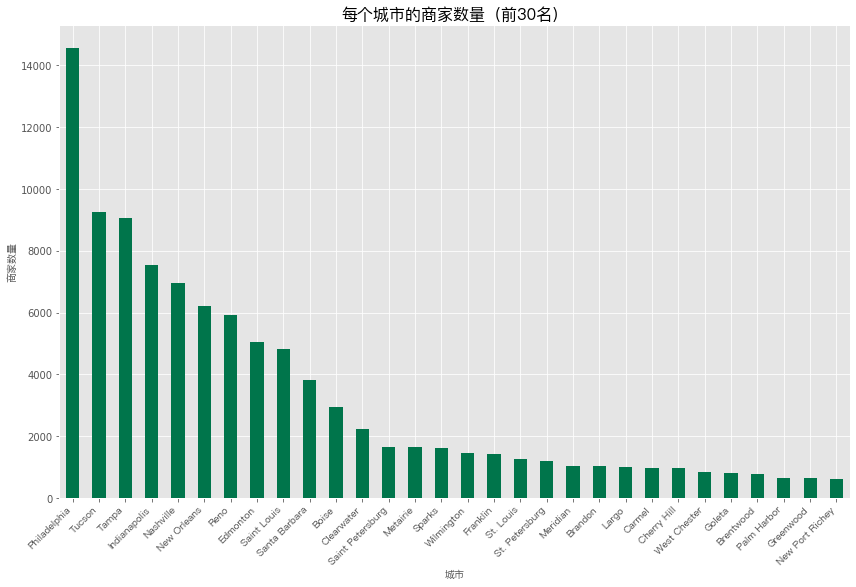

In [7]:
# 按城市分组并计算商家数量
yelp_business_groups = business_df.groupby('city').count()
yelp_business_city = yelp_business_groups['name']
yelp_business_city_sorted = yelp_business_city.sort_values(ascending=False)

# 绘制前30个城市的柱状图
ax = yelp_business_city_sorted[:30].plot(
    kind='bar',  figsize=(12, 8), color=main_color[0])
ax.set_xticklabels(
    yelp_business_city_sorted[:30].index, fontproperties=PingFang, rotation=45, ha='right')

ax.set_xlabel('城市', fontproperties=PingFang)
ax.set_ylabel('商家数量', fontproperties=PingFang)
plt.tight_layout()
plt.savefig('../images/01_每个城市的商家数量.png', dpi=600)
ax.set_title('每个城市的商家数量（前30名）', fontproperties=PingFang, fontsize=16)
plt.show()

查看不同类型的企业及其数量

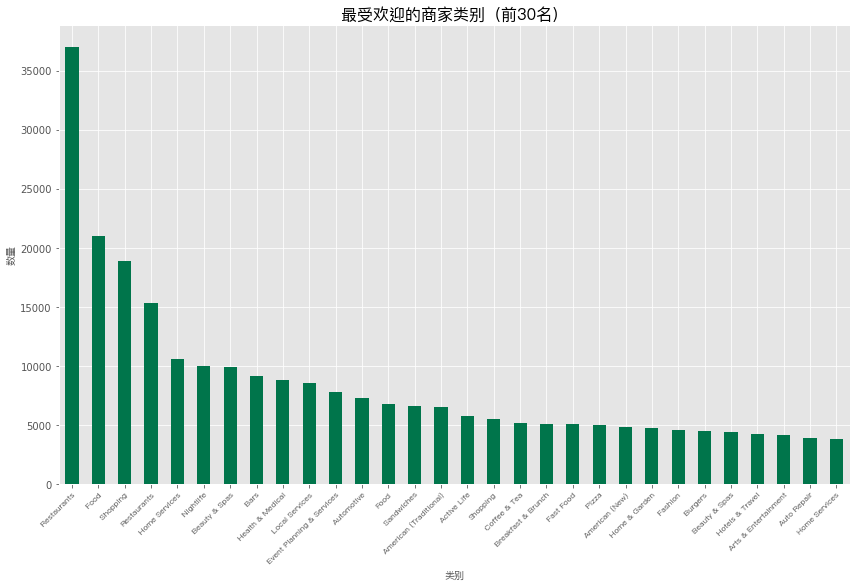

In [8]:
# 首先计算每个类别的出现次数
categories_dict = {}
for _ in business_df.categories:
    cat = str(_).split(',')
    for j in cat:
        if j not in categories_dict.keys():
            categories_dict[j] = 1
        else:
            categories_dict[j] += 1

categories_series = pd.Series(categories_dict)
categories_series.sort_values(ascending=False, inplace=True)

# 绘制前30个类别的柱状图
ax = categories_series[:30].plot(
    kind='bar', color=main_color[0], figsize=(12, 8))
ax.set_xticklabels(
    categories_series[:30].index, fontproperties=PingFang,
    rotation=45, ha='right', wrap=True,
    fontsize=8)


ax.set_xlabel('类别', fontproperties=PingFang)
ax.set_ylabel('数量', fontproperties=PingFang)
plt.tight_layout()
plt.savefig('../images/02_最受欢迎的商家类别.png', dpi=600)
ax.set_title('最受欢迎的商家类别（前30名）', fontproperties=PingFang, fontsize=16)
plt.show()

## 1.3. 商业和城市有序对及其计数

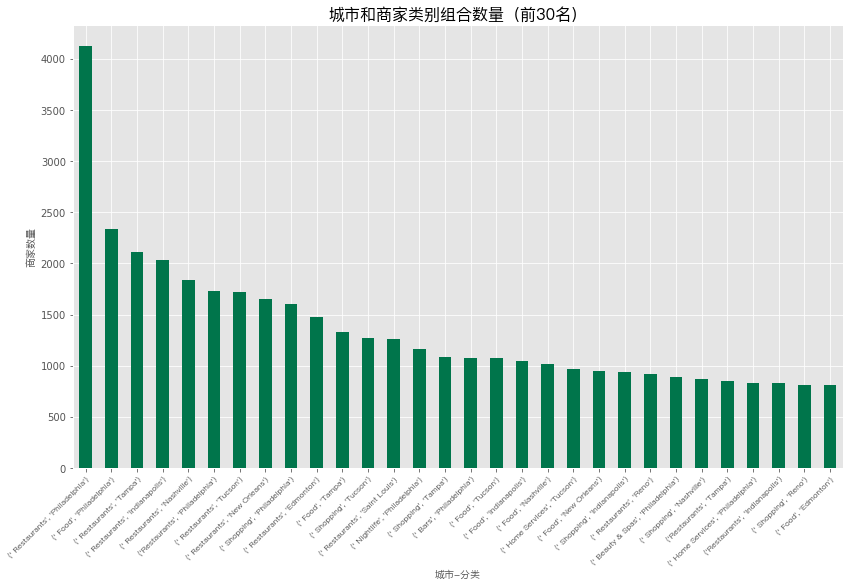

In [9]:
# 创建business_city字典，用于存储城市和分类的商家数量
business_city = {}
n = len(business_df)

for _ in range(n):
    k1 = str(business_df.categories.iloc[_]).split(',')
    k2 = business_df.city.iloc[_]
    for j in k1:
        k = (j, k2)
        if k not in business_city.keys():
            business_city[k] = 1
        else:
            business_city[k] += 1

# 将字典转换为Series并排序
business_city_series = pd.Series(business_city)
business_city_series.sort_values(ascending=False, inplace=True)

# 绘制前30个城市-分类的柱状图
fig, ax = plt.subplots(figsize=(12, 8))
business_city_series[:30].plot(kind='bar', color=main_color[0], ax=ax)

ax.set_xticklabels(
    business_city_series[:30].index,
    fontproperties=PingFang,
    rotation=45, ha='right',
    wrap=True, fontsize=8)

ax.set_xlabel('城市-分类', fontproperties=PingFang)
ax.set_ylabel('商家数量', fontproperties=PingFang)
plt.tight_layout()
plt.savefig('../images/03_城市和商家类别组合数量.png', dpi=600)
ax.set_title('城市和商家类别组合数量（前30名）', fontproperties=PingFang, fontsize=16)
plt.show()

可以看出，Yelp 上列出的多数商家是餐馆、购物场所和娱乐中心。对于这组数据（来自 Yelp 网站），拥有最多商家的主要城市是`Las Vegas`, `Phoenix`,和`Scottsdale`。

# 2 从评论文本预测Yelp评分

In [10]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score

In [11]:
# 筛选出所有属于"Restaurant"类别的商家
restaurants = business_df[business_df['categories'].str.contains(
    'Restaurant') == True]

# 筛选出那些其 business_id 存在于上面筛选出的商家ID列表中的评论
restaurant_reviews = review_df[review_df.business_id.isin(
    restaurants['business_id']) == True]

print(f"restaurant_reviews 数据框的维度：{restaurant_reviews.shape}")

restaurant_reviews 数据框的维度：(4724684, 9)


In [12]:
# 计算训练集大小，取整个数据集的70%
train_size = int(len(restaurant_reviews) * 0.7)

# 将前70%的数据分配给训练集
train = restaurant_reviews[:train_size]

# 将剩余的30%的数据分配给测试集
test = restaurant_reviews[train_size:]

print(f"训练数据集维度： {train.shape}")
print(f"测试数据集维度： {test.shape}")

训练数据集维度： (3307278, 9)
测试数据集维度： (1417406, 9)


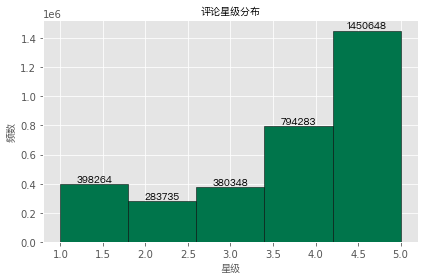

In [13]:
# 筛选出需要的列
train = train[['text', 'stars']]

counts, bins, patches = plt.hist(
    train['stars'], bins=5, color=main_color[0], edgecolor='black')

# 在柱子上方添加数值标签
for count, patch in zip(counts, patches):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    plt.text(x, y, str(int(count)), ha='center',
             va='bottom', fontproperties=PingFang)

# 添加图形标题和坐标轴标签
plt.title('评论星级分布', fontproperties=PingFang)
plt.xlabel('星级', fontproperties=PingFang)
plt.ylabel('频数', fontproperties=PingFang)

plt.tight_layout()
plt.savefig('../images/05_评论星级分布.png', dpi=600)
plt.show()

正如我在探索完整的评论集时所看到的那样，这个样本明显偏向于4星和5星评论。我不认为这是我想要平衡数据集的事情，但当我查看模型准确性时，我希望意识到这一点。

在数据准备方面，最初我只需要对我的评分变量进行独热编码。这将给我5个二进制列，每个评级级别一个。

In [14]:
# 将 'stars' 列独热编码，为列中的每个唯一值创建一个新的列，
# 如果该行在原始列中对应的值为该值，则新列为1，否则为0
train = pd.get_dummies(train, columns=['stars'])
train.head()

,text,stars_1,stars_2,stars_3,stars_4,stars_5
0,"If you decide to eat here, just be aware it is...",False,False,True,False,False
2,Family diner. Had the buffet. Eclectic assortm...,False,False,True,False,False
3,"Wow! Yummy, different, delicious. Our favo...",False,False,False,False,True
4,Cute interior and owner (?) gave us tour of up...,False,False,False,True,False
5,I am a long term frequent customer of this est...,True,False,False,False,False


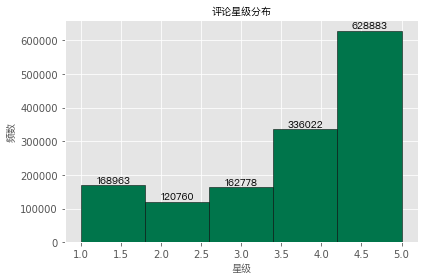

In [15]:
# 筛选出需要的列
test = test[['text', 'stars']]

counts, bins, patches = plt.hist(
    test['stars'], bins=5, color=main_color[0], edgecolor='black')

# 在柱子上方添加数值标签
for count, patch in zip(counts, patches):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    plt.text(x, y, str(int(count)), ha='center',
             va='bottom', fontproperties=PingFang)

# 添加图形标题和坐标轴标签
plt.title('评论星级分布', fontproperties=PingFang)
plt.xlabel('星级', fontproperties=PingFang)
plt.ylabel('频数', fontproperties=PingFang)

plt.tight_layout()
plt.savefig('../images/05_测试集评论星级分布.png', dpi=600)
plt.show()

In [16]:
# 将 'stars' 列转换为虚拟/哑变量（one-hot编码）
# 这会为 'stars' 列中的每个唯一值创建一个新的列，如果该行在原始列中对应的值为该值，则新列为1，否则为0
test = pd.get_dummies(test, columns=['stars'])

print(f"现在训练数据集维度： {train.shape}")
print(f"现在测试数据集维度： {test.shape}")

现在训练数据集维度： (3307278, 6)
现在测试数据集维度： (1417406, 6)


## 朴素贝叶斯线性模型

使用朴素贝叶斯线性分类器和`TfidfVectorizer`，将评论文本转换为`TF-IDF`加权的词向量，为NLP问题建立一个基线模型。

> 通过比较词在不同星级评论中的出现频率，计算条件概率，从而预测评论的星级。

In [17]:
# 设置TfidfVectorizer，限制最多使用2000个最重要的特征（单词），以构建词向量模型。
max_features = 2000
tfidf = TfidfVectorizer(max_features = max_features)

应用朴素贝叶斯模型，计算给定词汇（如"这", "餐厅", "很", "糟糕"）在不同星级评论下的条件概率，并通过拉普拉斯平滑处理未见过的单词。

> 使用得到的朴素贝叶斯概率作为特征，结合逻辑回归模型来预测评论的星级，从而提高模型的预测精度和解释性。

In [18]:
# 使用sklearn pipeline创建管道：
# 首先使用TfidfVectorizer（tfidf）将文本转换为TF-IDF特征。
# 然后，利用朴素贝叶斯特征转换器（NBFeatures）计算概率特征。
# 最后，将这些特征用于逻辑回归模型（LogisticRegression）进行最终的分类。

lr = LogisticRegression(max_iter=1000) # 初始化逻辑回归模型
nb = NBFeatures(1)  # 初始化朴素贝叶斯特征转换器，参数1可能表示使用拉普拉斯平滑
pl = Pipeline([
    ('tfidf', tfidf),  # 第一步：TF-IDF向量化
    ('nb', nb),        # 第二步：计算朴素贝叶斯概率特征
    ('lr', lr)         # 第三步：逻辑回归分类
])

由于原始星级评分包含多个类别（1星到5星），以下代码将这些评分转换成多个二分类问题，也就是对每个类别（星级），分别预测评论属于该星级的概率。

In [19]:
class_names = ['stars_1', 'stars_2', 'stars_3', 'stars_4', 'stars_5']
scores = []  # 存储每个类别的交叉验证分数
preds = np.zeros((len(test), len(class_names)))  # 初始化一个用于存储预济结果的数组

# 遍历每个星级类别，对每个类别进行模型训练和预测
for _, class_name in enumerate(class_names):
    train_target = train[class_name]  # 获取当前星级类别的目标值

    # 计算当前类别的交叉验证分数
    cv_score = np.mean(cross_val_score(estimator=pl,
                                       X=train['text'].values,
                                       y=train_target,
                                       cv=3,
                                       scoring='accuracy'))

    scores.append(cv_score)  # 添加当前星级的分数到列表

    print('类别的CV评分 {} 是 {}'.format(class_name, cv_score))  # 打印当前星级的交叉验证分数

    pl.fit(train['text'].values, train_target)  # 使用当前类别的数据训练模型
    preds[:, _] = pl.predict_proba(test['text'].values)[
        :, 1]  # 对测试集进行概率预测并存储结果

类别的CV评分 stars_1 是 0.9385818186436096
类别的CV评分 stars_2 是 0.9127007164199683
类别的CV评分 stars_3 是 0.8885566922405675
类别的CV评分 stars_4 是 0.7751422771233626
类别的CV评分 stars_5 是 0.8210960796159258


使用 sklearn 的 classification_report 生成分类模型的性能报告<br>
`y_true`: 真实的标签，通过从 test_sample 数据集的 class_names 列中取最大值的索引获得<br>
`y_pred`: 预测的标签，通过从预测结果 preds 中取最大值的索引获得

In [20]:
NBF_report = metrics.classification_report(
    y_true=np.argmax(test[class_names].values, axis=1),
    y_pred=np.argmax(preds, axis=1))
print(NBF_report)

              precision    recall  f1-score   support

           0       0.69      0.82      0.75    168963
           1       0.50      0.26      0.34    120760
           2       0.52      0.34      0.41    162778
           3       0.53      0.45      0.48    336022
           4       0.74      0.89      0.81    628883

    accuracy                           0.66   1417406
   macro avg       0.59      0.55      0.56   1417406
weighted avg       0.64      0.66      0.64   1417406



## 2.2 神经网络模型

NLP部分将使用基于推特语料库的200维GloVe嵌入作为词向量，使用Keras框架来构建和训练一个神经网络模型，以提升对评论文本的分类精度和解释能力。

In [33]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [22]:
lengths = review_df['text'].str.len()

# 计算并打印关键统计量
print("最小文本长度：", lengths.min())
print("最大文本长度：", lengths.max())
print("文本平均长度：", lengths.mean())
print("文本中位数长度：", lengths.median())
print("文本长度的标准差：", lengths.std())

最小文本长度： 1
最大文本长度： 5000
文本平均长度： 567.7644364746477
文本中位数长度： 406.0
文本长度的标准差： 527.257808524903


In [23]:
# 设置词嵌入的维度为200，这意味着每个词将被表示为一个300维的向量
embed_size = 200
# 设置最大特征数（词汇表大小）为50,000，即在模型中最多使用50,000个不同的词
max_features = 50000
# 设置最大序列长度为600，即每条评论最多使用200个词
maxlen = 600

embedding_file = '../GloVe/Twitter/glove.twitter.27B.200d.txt'

embeddings_index = {}

with open(embedding_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        except ValueError as e:
            # print(f"跳过行：{line}")
            continue

In [24]:
print(len(embeddings_index))

1193514


In [25]:
# 定义目标类别的列名，这里包含从1星到5星的评价
class_names = ['stars_1', 
               'stars_2',
               'stars_3', 
               'stars_4',
               'stars_5']

# 从train数据集中提取这些列的值，作为模型的目标变量y
y = train[class_names].values

使用Keras的`pad_sequences`方法对分词后的文本数据进行填充处理，以确保所有向量具有统一的长度，满足神经网络模型的输入要求。

In [26]:
# 初始化一个Tokenizer对象，设置最大词汇量为之前定义的max_features
tokenizer = Tokenizer(num_words=max_features)

# 用train数据集的文本列来训练tokenizer，构建词汇索引
tokenizer.fit_on_texts(list(train['text'].values))

# 将训练和测试集的文本转换为整数序列，根据每个词在tokenizer词汇表中的索引
X_train = tokenizer.texts_to_sequences(train['text'].values)
X_test = tokenizer.texts_to_sequences(test['text'].values)

# 使用pad_sequences方法将训练集和测试集的序列填充到相同的最大长度
# 不足的部分使用默认值填充（默认为0）
x_train = pad_sequences(X_train, maxlen=maxlen)
x_test = pad_sequences(X_test, maxlen=maxlen)


初始化词嵌入，将不在预训练嵌入中的词设置为零向量，并允许在模型训练过程中调整这些嵌入。

使用预训练的推特嵌入作为起点，优化模型以适应具体的应用场景和数据集。

In [27]:
# 获取Tokenizer的词索引字典
word_index = tokenizer.word_index

# 确定嵌入矩阵的大小：取最大特征数和词索引长度的较小值
nb_words = min(max_features, len(word_index))

# 创建一个全零矩阵，其形状为(nb_words, embed_size)，用于存储词向量
embedding_matrix = np.zeros((nb_words, embed_size))

missed = []

for word, _ in word_index.items():
    # 只处理索引小于max_features的词，以保持embedding_matrix大小合适
    if _ >= max_features: break
    # 从预训练的词向量中获取当前词的向量
    embedding_vector = embeddings_index.get(word)
    # 如果找到了词向量，将其添加到embedding_matrix中对应的位置
    if embedding_vector is not None:
        embedding_matrix[_] = embedding_vector
    else:
        # 如果未找到词向量，将该词记录到missed列表中
        missed.append(word)

In [28]:
len(missed)
missed[:110]

["it's",
 "don't",
 "i've",
 "i'm",
 "didn't",
 '2',
 '5',
 '3',
 "wasn't",
 "can't",
 '4',
 '10',
 "you're",
 '1',
 "that's",
 "i'll",
 "i'd",
 '20',
 "won't",
 '30',
 "couldn't",
 '6',
 '15',
 "there's",
 "isn't",
 "doesn't",
 '8',
 "they're",
 '7',
 "wouldn't",
 '50',
 "haven't",
 "weren't",
 "we've",
 '9',
 "you'll",
 '12',
 '00',
 "we're",
 '45',
 '25',
 "aren't",
 '11',
 "we'll",
 '40',
 'covid',
 '100',
 '99',
 "let's",
 "you've",
 "they've",
 "hadn't",
 "you'd",
 "what's",
 '14',
 "we'd",
 "he's",
 '13',
 '16',
 '18',
 '95',
 "would've",
 '2nd',
 '35',
 "shouldn't",
 '75',
 '19',
 '24',
 "she's",
 "friend's",
 '0',
 "here's",
 '17',
 '1st',
 "they'll",
 "wife's",
 '60',
 "could've",
 "mcdonald's",
 "husband's",
 '21',
 '30pm',
 '90',
 "they'd",
 "hasn't",
 '3rd',
 "mother's",
 "chef's",
 'yelpers',
 '4th',
 '22',
 '7pm',
 '80',
 '6pm',
 "tv's",
 "y'all",
 "it'll",
 "everyone's",
 "should've",
 '70',
 'charbroiled',
 "b's",
 "pat's",
 "valentine's",
 "geno's",
 "mary's",
 "who's

设置使用预训练的 GloVe 嵌入，并将 `trainable` 设置为 `true`，以允许对嵌入进行微调，有助于提高模型对特定数据集的适应性和准确性。

实现早停（early stopping）机制来防止过拟合，当检测到验证集上的性能不再提升时自动停止训练。同时，使用检查点（checkpoint）保存验证性能最好的模型参数。

In [29]:
# 定义模型的输入层，形状为 (maxlen,)，代表每个输入样本的长度
inp = Input(shape=(maxlen,))

# 创建嵌入层，使用预先加载的词嵌入矩阵，并设置为可训练
x = Embedding(max_features, embed_size, weights=[
              embedding_matrix], trainable=True)(inp)

# 添加空间丢弃层，以减少模型对特定样本位置的过拟合
x = SpatialDropout1D(0.5)(x)

# 使用双向LSTM层处理时间序列数据
x = Bidirectional(layer=LSTM(units=40, return_sequences=True))(x)

# 在双向LSTM之后，再添加一个双向GRU层，以增强模型的学习能力
x = Bidirectional(layer=GRU(units=40, return_sequences=True))(x)

# 使用全局平均池化和全局最大池化层来提取特征
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)

# 将平均池化和最大池化的结果合并，用于捕获不同的特征表示
conc = concatenate([avg_pool, max_pool])

# 输出层，使用sigmoid激活函数，输出5个单位
outp = Dense(units=5, activation='sigmoid')(conc)
# 定义模型，输入为inp，输出为outp
yelp_review_model = Model(inputs=inp, outputs=outp)
# 定义早停回调函数，当验证损失不再改善时提前终止训练
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

# 检查点回调函数，保存验证损失最好的模型
checkpoint = ModelCheckpoint(
    monitor='val_loss',
    save_best_only=True,
    filepath='../assets/yelp_lstm_gru_weights.hdf5')

# 编译模型，使用二元交叉熵损失函数和Adam优化器，同时监控准确率
yelp_review_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

2024-06-05 04:11:57.253884: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 04:11:57.918510: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22136 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:5a:00.0, compute capability: 8.9


In [30]:
# 训练模型，并在训练过程中使用早停和检查点回调函数
yelp_review_model.fit(
    x_train,  # 训练数据集的输入
    y,        # 训练数据集的标签
    batch_size=512,  # 批处理大小，每次更新权重时使用的样本数
    epochs=50,  # 训练周期数，整个数据集将被训练50次
    validation_split=0.2,  # 验证集比例，从训练数据中分割20%作为验证集
    callbacks=[earlystop, checkpoint]  # 回调函数列表，包括早停和检查点回调函数
)

Epoch 1/50


2024-06-05 04:12:11.780597: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2024-06-05 04:12:12.846366: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


5168/5168 [==============================] - 540s 103ms/step - loss: 0.2652 - accuracy: 0.6793 - val_loss: 0.2327 - val_accuracy: 0.7256
Epoch 2/50
5168/5168 [==============================] - 528s 102ms/step - loss: 0.2391 - accuracy: 0.7156 - val_loss: 0.2257 - val_accuracy: 0.7346
Epoch 3/50
5168/5168 [==============================] - 528s 102ms/step - loss: 0.2323 - accuracy: 0.7250 - val_loss: 0.2238 - val_accuracy: 0.7366
Epoch 4/50
5168/5168 [==============================] - 528s 102ms/step - loss: 0.2283 - accuracy: 0.7308 - val_loss: 0.2219 - val_accuracy: 0.7406
Epoch 5/50
5168/5168 [==============================] - 529s 102ms/step - loss: 0.2254 - accuracy: 0.7348 - val_loss: 0.2209 - val_accuracy: 0.7413
Epoch 6/50
5168/5168 [==============================] - 528s 102ms/step - loss: 0.2231 - accuracy: 0.7381 - val_loss: 0.2206 - val_accuracy: 0.7420
Epoch 7/50
5168/5168 [==============================] - 527s 102ms/step - loss: 0.2212 - accuracy: 0.7412 - val_loss: 0.221

## 模型评估

In [31]:
# 使用训练好的模型预测测试集
y_test = yelp_review_model.predict(
    [x_test],
    batch_size=1024,
    verbose=1
)

# 评估模型在测试集上的表现
yelp_review_model.evaluate(
    x_test,
    test[class_names].values,
    verbose=1,
    batch_size=1024
)

NN_report = metrics.classification_report(
    np.argmax(test[class_names].values, axis=1),
    np.argmax(y_test, axis=1)
)

print(NN_report)

yelp_review_model.save('../assets/yelp_review_model.h5')

1385/1385 [==============================] - 71s 52ms/step - loss: 0.2269 - accuracy: 0.7351
              precision    recall  f1-score   support

           0       0.76      0.86      0.81    168963
           1       0.57      0.49      0.53    120760
           2       0.63      0.56      0.59    162778
           3       0.65      0.54      0.59    336022
           4       0.81      0.90      0.85    628883

    accuracy                           0.74   1417406
   macro avg       0.68      0.67      0.67   1417406
weighted avg       0.72      0.74      0.73   1417406



# 3 清理评论数据

## 3.1 删除不需要的列
- `text`: 评论文本,
- `useful`: 认为有用的人数,
- `date`: 日期

剩下的列是 `user_id`, `business_id` 和 `stars`.

In [32]:
yelp_cleaned = review_df.drop(['text',
                               'votes.useful',
                               'votes.cool',
                               'date',
                               'votes.funny'], axis=1)
yelp_cleaned.head()

KeyError: "['votes.useful', 'votes.cool', 'votes.funny'] not found in axis"

## 3.2 合并数据
合并业务数据`yelp_academic_dataset_business.csv`与评论数据`yelp_academic_dataset_review.csv`
将业务数据和评论数据利用 'business_id' 为主键合并。像business的 'city' 和 'categories' 这样的信息是从业务数据文件中获取的。

In [ ]:
yelp_full = yelp_cleaned.merge(
    business_df[['city',
                   'categories',
                   'business_id']], how='inner', on='business_id')

df = yelp_full.dropna()

## 3.3 获取评论数量最多的前30名业务类别和城市

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
review_business_city = get_top_m_num_reviews_for_city_and_business(
    df, 10)
review_business_city[:30].plot(kind='bar', color=main_color[0], ax=ax)

ax.set_xticklabels(
    review_business_city[:30].index,
    fontproperties=PingFang,
    rotation=45, ha='right',
    wrap=True, fontsize=8
)
ax.set_xlabel('城市-业务类别', fontproperties=PingFang)
ax.set_ylabel('评论数量', fontproperties=PingFang)
plt.tight_layout()
plt.savefig('../images/04_获得评论最多的城市和商家类别组合.png', dpi=600)
ax.set_title('获得评论最多的城市和商家类别组合（前30名）', fontproperties=PingFang, fontsize=16)
plt.show()

In [ ]:
df.to_csv('../data/Yelp_final.csv', index=False)